FOR LANGUAGES : MARATHI, GUJARATI, KANNADA, HINDI
not needed ; fixed (1) code

In [1]:
%env CUDA_VISIBLE_DEVICES= 5


env: CUDA_VISIBLE_DEVICES=5


In [2]:
import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'

## IndicTrans2

In [3]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)

cuda


In [4]:
import transformers
print(transformers.__version__)

4.44.2


In [5]:
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)

pir= poss_indic_rel.possible_relations
pir

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings

In [7]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

In [8]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir,  quantization)

ip_en_ind = IndicProcessor(inference=True)

# Util Functions

In [ ]:


def resolve_logits_for_best_beam(outputs, num_beams):
    """ Resolve the logits from the best beam, using model output from a generate call.
        For a shape [tokens?, batch_size*num_beams, vocab], returns [tokens?, batch_size, vocab]

        Assumes num_return_sequences=1."""

    print("length of output beam", len(outputs.beam_indices))
    print("shape of beam_indices", outputs.beam_indices.shape)
    print("shape of logits", (outputs.logits[0].shape))
    print("length of logits", len(outputs.logits))
    print("length od outputs", len(outputs))
    best_logits = []
    beam_indices = []
    for i in range(len(outputs.logits) - 1):
        beam_indices.append(outputs.beam_indices[:, i-1].tolist()) 
    print("length of beam_indices", len(beam_indices))
    print("beam_indices", beam_indices)
    for beam_index, logits in zip(beam_indices, outputs.logits):
        beam_index = [ idx if idx != -1 else ((num_beams*(i+1))-1) for i, idx in enumerate(beam_index) ]
        best_logits.append(logits[beam_index,:])

    return best_logits




def get_logits_for_span(logits, translations, tokenizer, search_spans, span_encodings, lang):
    """ Given search spans, returns the logits before the span was generated.

    Args:
        logits (tuple[Tensor]): Tuple of tensors, of shape [tokens?, batch_size, vocab]
        sequences (tuple[list[int]]): Tokenized output sequences.
        tokenizer (PreTrainedTokenizerBase): Tokenizer for the model.
        search_spans (list[str]): batch_size spans to search for. Must be present in the generated sequences.

    Returns:
        Tensor: Tensor of shape [batch_size, vocab] indicating the logits before the span for each batch element.
    """
    if isinstance(search_spans, str):
        search_spans = [ search_spans ] * len(translations)

    # with tokenizer.as_target_tokenizer():   
    #     detok_outputs = tokenizer.batch_decode(translations, skip_special_tokens=True)

    # positions = [ output.index(span) for output, span in zip(translations, search_spans) ]
    logit_pos = [  ]

    for seq,  span,  in zip(translations,  search_spans): 
        # print("Span to search for:", span, span_encodings[lang])
        key = next((k for k in span_encodings[lang].keys() if span in k), "None")
        subtokens = span_encodings[lang][key]
        print("subtokens", subtokens)
        print("for span:", span, "subtokens", subtokens)
        print("seq", seq)
        idx = 0
        while idx < len(seq)-1:
            if any(idx+i < len(seq) and seq[idx+i] == tok for i, tok in enumerate(subtokens)): 
                # print( "found", idx)
                break
            idx += 1
        logit_pos.append(idx-1)
    
    print("logit_pos", logit_pos)
    print("Dimensions of logits", logits[0].shape, len(logits))

    selected_logits = []
    # Iterate over each batch and corresponding token position
    for batch, token in enumerate(logit_pos):
        print("batch, token", batch, token)
        print("len(logits)", len(logits))
        print("Shape of logits", logits[0].shape)
        # print("logits token", logits[token])
        print("logits 1st item 1st row",logits[0][0])
        # Extract logits for the specific token position in the current batch
        current_logit = logits[token][batch, :]
        # current_logit = logits[token][0]
        
        # Append the selected logit to the list
        selected_logits.append(current_logit)

    # Stack the list of selected logits into a tensor
    selected_logits = torch.stack(selected_logits)

    return selected_logits
        
    # return selected_logits
    # return torch.stack([ logits[token][batch,:] for batch, token in enumerate(logit_pos) ])


In [10]:
def get_search_spans(inp_sents, tgt_lang, translations):
    search_spans= []
    root_amb_words=[]
    # print("inp_sents", inp_sents)
    for idx, inp in enumerate(inp_sents):
        # check which word from ambiguos_Wwords in present in the input sentence
        for word in ambiguos_words:
            if word in inp:
                curr_amb_word= word
        root_amb_words.append(curr_amb_word)

        # get the possible relations for the current ambiguous word
        possible_relations= pir[curr_amb_word][tgt_lang].keys()
        # print("Possible relations for the word", curr_amb_word, "in", tgt_lang, "are", possible_relations)

        # find the word in the translation from the possible relations. if not found print the translation
        for rel in possible_relations:
            if rel in translations[idx]:
                # print("Relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx], "at ", translations[idx].index(rel), "\nso sentece is", translations[idx][translations[idx].index(rel):])
                search_spans.append(rel)
                break
        else:
            # print("No relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx])
            search_spans.append(translations[idx][0])
    # print("Search spans are", search_spans)
    return root_amb_words, search_spans
       



In [11]:



def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, span_encodings):
    translations = []
    start_logits = []
    root_amb_words = []
    searched_spans = []
    for i in tqdm(range(0, len(input_sentences), BATCH_SIZE)):
        batch = input_sentences[i : i + BATCH_SIZE]
        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)
        with torch.no_grad():
            # generated_tokens = model.generate(
            outputs = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1, # TODO temp
                output_scores=True,
                output_logits=True,
                return_dict_in_generate=True,

            )
            # print("Length of outputs.logits actual", len(outputs.logits))
            # print("Shape of outputs.logits actual", outputs.logits[0].shape)

            # print("Length of outputs.beam_indices actual", len(outputs.beam_indices))
            # print("Shape of outputs.beam_indices actual", outputs.beam_indices.shape)
            
            outputs.beam_indices = outputs.beam_indices.cpu()
            outputs.logits = tuple(logits.cpu() for logits in outputs.logits)               
        # Decode the generated tokens into text
        generated_tokens = outputs.sequences
        # print("len generated_tokens: ", (generated_tokens[0]).shape)
        # print("1st generated token: ", generated_tokens[0])
        vector = generated_tokens.detach().cpu().tolist()
        # print("length of outputs vectors: ", len(vector), len(vector[0]))
        # print("vector of generated_tokens: ", vector)
        # print("1st vector: ", vector[0])



        with tokenizer.as_target_tokenizer():
            decoded_op = tokenizer.batch_decode(
                vector,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # print("1st decoded_op: ", decoded_op[0])
        # Postprocess the translations, including entity replacement
        transl = ip.postprocess_batch(decoded_op, lang=tgt_lang)

        # print("translations: ", transl)
        

        root_words, search_spans = get_search_spans(batch,  tgt_lang, transl)
        searched_spans += search_spans
        root_amb_words += root_words
        # print("length search_spans: ", len(search_spans))
        best_logits = resolve_logits_for_best_beam(outputs, num_beams=5)
        # print("length best_logits: ",len(best_logits))
        # print("length of best_logits: ", len(best_logits), (best_logits[0]).shape)

        start_logits += get_logits_for_span(best_logits, outputs.sequences, tokenizer, search_spans, span_encodings, tgt_lang)
        # start_logits += get_logits_for_span(best_logits, translations, tokenizer, search_spans)
        translations += transl
        del inputs
        torch.cuda.empty_cache()

    return translations, start_logits, root_amb_words, searched_spans

In [12]:
lang_script_list = [
                            
                           'mar_Deva', 
                         
                           'guj_Gujr', 
                          #  'tel_Telu',
                             'hin_Deva', 
                           'kan_Knda', 
                           ]

In [13]:
test_csv_folder = 'custom_test_csv'

In [14]:
lang_code_map = {
    'eng_Latn': 'en',
    'hin_Deva': 'hi',
    'guj_Gujr': 'gu',
    'kan_Knda': 'kn',
    'mal_Mlym': 'ml',
    'mar_Deva': 'mr',
    'tam_Taml': 'ta',
    'tel_Telu': 'te',
    'pan_Guru': 'pa',
    'ben_Beng': 'bn',
    'ory_Orya': 'or'
}


In [15]:
sents = []
with open('test_sentences_eng.txt', 'r') as f:
    sents = f.readlines()
sents = [sent.strip() for sent in sents if sent.find('child')==-1]
print(len(sents))

1809


In [16]:
SAMPLE_SIZE = 10
sents = sents[:SAMPLE_SIZE]
sents

['My grandmother is a Brahmin.',
 'My grandfather is a Brahmin.',
 'My uncle is a Brahmin.',
 'My aunt is a Brahmin.',
 'My brother-in-law is a Brahmin.',
 'My sister-in-law is a Brahmin.',
 'My cousin is a Brahmin.',
 'My nephew is a Brahmin.',
 'My niece is a Brahmin.',
 'My grandmother is a Kshatriya.']

# Execute Translations

In [ ]:
src_lang = "eng_Latn"
output_trnsl={}
output_logits={}

for lang in lang_script_list:
    tgt_lang = lang
    print(lang)
    translations, logits, root_amb_words, searched_spans = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind, span_encodings)
    output_trnsl[lang] = translations
    output_logits[lang] = logits


mar_Deva


  0%|          | 0/3 [00:00<?, ?it/s]/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
 33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 8])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [-1, -1, -1, 15]]
subtokens [32967]
for span: आजी subtokens [32967]
seq tensor([    2,  6457, 32967, 28125,    38,     4,     2,     1],
       device='cuda:0')
subtokens [56799, 4]
for span: आजोबा subtokens [56799, 4]
seq tensor([    2,  2953, 56799, 28125,   233,     4,     2,     1],
       device='cuda:0')
subtokens [41565, 4]
for span: काका subtokens [41565, 4]
seq tensor([    2,  2953, 41565, 28125,   233,     4,     2,     1],
       device='cuda:0')
subtokens [11701, 987, 4]
for span: मावशी subtokens [11701, 987, 4]
seq tensor([    2,  6457, 11701,   987, 28125,    38,     4,     2],
       device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 8
batch, to

 67%|██████▋   | 2/3 [00:01<00:00,  2.02it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 11
length od outputs 6
length of beam_indices 10
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 6, 10, 15], [0, 6, 10, 15], [0, 5, 10, 15], [0, 6, 10, 15], [0, 6, 10, 15], [0, 5, 10, -1], [-1, -1, -1, -1]]
subtokens [530, 7131, 1067]
for span: मेहुणा subtokens [530, 7131, 1067]
seq tensor([    2,  6010,   530,  7131,  1067, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [530, 7131, 1730]
for span: मेहुणी subtokens [530, 7131, 1730]
seq tensor([    2,  6457,   530,  7131,  1730, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [6702, 119, 22699]
for span: चुलत भाऊ subtokens [6702, 119, 22699]
seq tensor([    2,  6010,  6702,   119, 22699, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [11701, 987, 4]
for span: म subtokens [11701, 987, 4]
seq tensor([    2,  6010,  4300, 12291, 28125,    38,     4,   

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


length of output beam 2
shape of beam_indices torch.Size([2, 8])
shape of logits torch.Size([10, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
beam_indices [[-1, -1], [0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, -1]]
subtokens [4569, 362]
for span: भाची subtokens [4569, 362]
seq tensor([    2,  6457,  4569,   362, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [32967]
for span: आजी subtokens [32967]
seq tensor([    2,  6457, 32967, 64275,    38,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 8
batch, token 0 1
len(logits) 8
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4478, -0.4480,  1.1982,  ..., -0.4480, -0.4480, -0.4478],
       dtype=torch.float16)
batch, token 1 1
len(logits) 8
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4478, -0.4480,  1.1982,  ..., -0.4480, -0.4480, -0.4478],
       dtype=torch.float16)
guj_Gu

 33%|███▎      | 1/3 [00:00<00:00,  3.76it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 7])
shape of logits torch.Size([20, 122672])
length of logits 8
length od outputs 6
length of beam_indices 7
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15]]
subtokens [29498]
for span: દાદી subtokens [29498]
seq tensor([    2,  2562, 29498, 28125,    15,     4,     2], device='cuda:0')
subtokens [15588]
for span: દાદા subtokens [15588]
seq tensor([    2,  1551, 15588, 28125,    15,     4,     2], device='cuda:0')
subtokens [41565]
for span: કાકા subtokens [41565]
seq tensor([    2,  1551, 41565, 28125,    15,     4,     2], device='cuda:0')
subtokens [64851]
for span: કાકી subtokens [64851]
seq tensor([    2,  2562, 64851, 28125,    15,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 7
batch, token 0 1
len(logits) 7
Shape of logits torch.Size([4, 122672])
logits 1st item 1st row tensor([-0.5635, 

 67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [-1, -1, 10, 15]]
subtokens [1872, 2466]
for span: સાળો subtokens [1872, 2466]
seq tensor([    2, 11788,  1872,  2466, 28125,    15,     4,     2,     1],
       device='cuda:0')
subtokens [1872, 2651]
for span: સાળી subtokens [1872, 2651]
seq tensor([    2,  2562,  1872,  2651, 28125,    15,     4,     2,     1],
       device='cuda:0')
subtokens [24501]
for span: મ subtokens [24501]
seq tensor([    2, 11788,  6042, 18974,  3991, 28125,    15,     4,     2],
       device='cuda:0')
subtokens [980, 14910, 3204]
for span: ભત્રીજો subtokens [980, 14910, 3204]
seq tensor([    2, 11788,   980, 14910,  3204, 28125,    15,     4,     2],
       device='cuda:0')
logit_pos [1, 1, 7, 1

100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 11
length od outputs 6
length of beam_indices 10
beam_indices [[-1, -1], [0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, -1], [0, -1], [-1, -1]]
subtokens [980, 14910, 795]
for span: ભત્રીજી subtokens [980, 14910, 795]
seq tensor([    2,  2562,   980, 14910,   795, 28125,    15,     4,     2],
       device='cuda:0')
subtokens [29498]
for span: દાદી subtokens [29498]
seq tensor([    2,  2562, 29498, 64275,    15,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4136, -0.4136,  1.0811,  ..., -0.4136, -0.4136, -0.4133],
       dtype=torch.float16)
batch, token 1 1
len(logits) 10
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4136, -0.4136,  1.0811,  ..., -0.4136,

 33%|███▎      | 1/3 [00:00<00:00,  3.35it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 7])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [-1, -1, -1, -1]]
subtokens [29498, 12075]
for span: दादी subtokens [29498, 12075]
seq tensor([    2,  1653, 29498, 28125,    33,     6,     2], device='cuda:0')
subtokens [15588, 613, 6]
for span: दादा subtokens [15588, 613, 6]
seq tensor([    2,   790, 15588, 28125,    33,     6,     2], device='cuda:0')
subtokens [34059]
for span: चाचा subtokens [34059]
seq tensor([    2,   790, 34059, 28125,    33,     6,     2], device='cuda:0')
subtokens [60684]
for span: चाची subtokens [60684]
seq tensor([    2,  1653, 60684, 28125,    33,     6,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of logits torch.Size([4, 122672]) 8
batch, token 0 1
len(logits) 8
Shape of logits torch.Size([4, 12

 67%|██████▋   | 2/3 [00:00<00:00,  3.09it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 6, 10, 15], [0, 5, 10, 15], [0, 6, 10, 15], [-1, 5, 10, -1], [-1, -1, 10, -1]]
subtokens [27985]
for span: साला subtokens [27985]
seq tensor([    2,  2243, 27985, 28125,     8,     6,     2,     1,     1],
       device='cuda:0')
subtokens [18477]
for span: साली subtokens [18477]
seq tensor([    2,  1653, 18477,    24, 28125,     8,     6,     2,     1],
       device='cuda:0')
subtokens [49615, 2656, 3057]
for span: भाई subtokens [49615, 2656, 3057]
seq tensor([    2,  2243, 49615,  2656,  3057, 28125,     8,     6,     2],
       device='cuda:0')
subtokens [69840]
for span: भतीजा subtokens [69840]
seq tensor([    2,  2243, 69840, 28125,     8,     6,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of l

100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
beam_indices [[-1, -1], [0, 5], [0, 5], [0, 5], [0, 5], [1, 5], [1, 5], [1, -1]]
subtokens [39136, 795]
for span: भतीजी subtokens [39136, 795]
seq tensor([    2,  1653, 39136,   795,    24, 28125,     8,     6,     2],
       device='cuda:0')
subtokens [29498, 12075]
for span: दादी subtokens [29498, 12075]
seq tensor([    2,  1653, 29498, 64275,    33,     6,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 8
batch, token 0 1
len(logits) 8
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.2267, -0.2268,  1.9307,  ..., -0.2269, -0.2268, -0.2268],
       dtype=torch.float16)
batch, token 1 1
len(logits) 8
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.2267, -0.2268,  1.9307,  ..., -0.2269, -0.2268, -0.2268],
  

 33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 11, 15], [1, 5, 10, 15], [0, -1, 10, 16]]
subtokens [4565, 35330]
for span: ಅಜ್ಜಿ subtokens [4565, 35330]
seq tensor([    2,  1586,  4565, 35330, 28125,   194,     4,     2,     1],
       device='cuda:0')
subtokens [4565, 35330]
for span: ಅಜ್ಜ subtokens [4565, 35330]
seq tensor([    2,  1586, 44928,  3564, 28125,     4,     2,     1,     1],
       device='cuda:0')
subtokens [2950, 378]
for span: ಚಿಕ್ಕಪ್ಪ subtokens [2950, 378]
seq tensor([    2,  1586,  2950,   378,  3564, 28125,     4,     2,     1],
       device='cuda:0')
subtokens [2950, 1476, 4]
for span: ಚಿಕ್ಕಮ್ಮ subtokens [2950, 1476, 4]
seq tensor([    2,  1586,  2950,  1476,  3564, 28125,   104,     4,     2],
       device='cuda:0')
logit_pos [1, 7, 1, 1]
D

 67%|██████▋   | 2/3 [00:00<00:00,  2.75it/s]

length of output beam 4
shape of beam_indices torch.Size([4, 10])
shape of logits torch.Size([20, 122672])
length of logits 12
length od outputs 6
length of beam_indices 11
beam_indices [[-1, -1, -1, -1], [0, 5, 10, 15], [0, 5, 10, 15], [1, 5, 10, 15], [0, 5, 10, 15], [1, 5, 10, 15], [0, 6, 10, 17], [0, 5, 11, 15], [-1, -1, 10, 15], [-1, -1, 10, -1], [-1, -1, -1, -1]]
subtokens [1364, 58831]
for span: ನ subtokens [1364, 58831]
seq tensor([    2,  1586,  3373,   158,  3564, 28125,     4,     2,     1,     1],
       device='cuda:0')
subtokens [213, 24430]
for span: ಅತ್ತಿಗೆ subtokens [213, 24430]
seq tensor([    2,  1586,   213, 24430, 28125,  1384,     4,     2,     1,     1],
       device='cuda:0')
subtokens [1364, 58831]
for span: ನ subtokens [1364, 58831]
seq tensor([    2,  1586, 34385,  2182, 15841,  2603,  3564, 28125,     4,     2],
       device='cuda:0')
subtokens [1364, 58831]
for span: ನ subtokens [1364, 58831]
seq tensor([    2,  1586, 34385,  5999, 28125,  6842, 10189,    

100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
beam_indices [[-1, -1], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5], [0, 5], [0, -1]]
subtokens [34385, 6324, 3658]
for span: ಸೋದರ ಸೊಸೆ subtokens [34385, 6324, 3658]
seq tensor([    2,  1586, 34385,  6324,  3658, 28125,  1384,     4,     2],
       device='cuda:0')
subtokens [4565, 35330]
for span: ಅಜ್ಜಿ subtokens [4565, 35330]
seq tensor([    2,  1586,  4565, 35330,  3564, 64275,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.8945, -0.8940,  1.0840,  ..., -0.8940, -0.8940, -0.8940],
       dtype=torch.float16)
batch, token 1 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.8945, -0.8940,  1.0840,  ..., -0.8

In [ ]:
# dataframe from the translations, logits and the root ambiguous words, searched spans
import pandas as pd

df = pd.DataFrame()
df['sentences'] = sents
df['root_ambiguous_words'] = root_amb_words
for lang in lang_script_list:
     
    # following 2 can be commented out to reduce the size of the dataframe
    df['searched_spans_'+lang] = searched_spans
    df['transl_'+lang_code_map[lang]] = output_trnsl[lang]
    df['logits_'+lang_code_map[lang]] = output_logits[lang]

df.head()

,sentences,root_ambiguous_words,searched_spans_mar_Deva,transl_mr,logits_mr,searched_spans_guj_Gujr,transl_gu,logits_gu,searched_spans_hin_Deva,transl_hi,logits_hi,searched_spans_kan_Knda,transl_kn,logits_kn
0,My grandmother is a Brahmin.,grandmother,ಅಜ್ಜಿ,माझी आजी ब्राह्मण आहे.,"[tensor(-0.8042, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,મારી દાદી બ્રાહ્મણ છે.,"[tensor(-0.7539, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,मेरी दादी ब्राह्मण हैं।,"[tensor(-0.7910, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು.,"[tensor(-1.0566, dtype=torch.float16), tensor(..."
1,My grandfather is a Brahmin.,grandfather,ಅಜ್ಜ,माझे आजोबा ब्राह्मण आहेत.,"[tensor(-0.6016, dtype=torch.float16), tensor(...",ಅಜ್ಜ,મારા દાદા બ્રાહ્મણ છે.,"[tensor(-0.5103, dtype=torch.float16), tensor(...",ಅಜ್ಜ,मेरे दादा ब्राह्मण हैं।,"[tensor(-0.5205, dtype=torch.float16), tensor(...",ಅಜ್ಜ,ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.4062, dtype=torch.float16), tensor(..."
2,My uncle is a Brahmin.,uncle,ಚಿಕ್ಕಪ್ಪ,माझे काका ब्राह्मण आहेत.,"[tensor(-1.0234, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,મારા કાકા બ્રાહ્મણ છે.,"[tensor(-0.9272, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,मेरे चाचा ब्राह्मण हैं।,"[tensor(-0.8447, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.1094, dtype=torch.float16), tensor(..."
3,My aunt is a Brahmin.,aunt,ಚಿಕ್ಕಮ್ಮ,माझी मावशी ब्राह्मण आहे.,"[tensor(-1.7686, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,મારી કાકી બ્રાહ્મણ છે.,"[tensor(-1.6504, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,मेरी चाची ब्राह्मण हैं।,"[tensor(-1.4668, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ.,"[tensor(-1.3389, dtype=torch.float16), tensor(..."
4,My brother-in-law is a Brahmin.,brother-in-law,ನ,माझा मेहुणा ब्राह्मण आहे.,"[tensor(-1.5283, dtype=torch.float16), tensor(...",ನ,મારો સાળો બ્રાહ્મણ છે.,"[tensor(-1.3604, dtype=torch.float16), tensor(...",ನ,मेरा साला ब्राह्मण है।,"[tensor(-0.8120, dtype=torch.float16), tensor(...",ನ,ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(0.0098, dtype=torch.float16), tensor(0..."


In [19]:
# for all sentences:
#    for all langs:
#     for the given root ambiguous word, get the possible relations in the target language
#      group the possible relations into matriarchal and patriarchal
#       <*>find the logits for the words in matrirachi and patriachal relations
#       find the sum over respective sets and take difference of both sums
#       if difference is positive, then the wordXlang is matriarchal, else patriarchal
#     Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix


In [20]:
final_res={}

In [ ]:
# for each row of dataframe with index i
for i in range(len(df)):
    # print("Index: ", i)
    for lang in lang_script_list:
         
        # print("Lang: ", lang)
        if final_res.get(lang, None) is None:
            final_res[lang] = {}
        root_amb_word = df.loc[i, 'root_ambiguous_words']
        # print("Root ambiguous word: ", root_amb_word)
        possible_relations = list(pir[root_amb_word][lang].keys())
        # print("Possible relations: ", possible_relations)
        matriarchal = []
        patriarchal = []
        for rel in possible_relations:
            if 'F' == pir[root_amb_word][lang][rel]['relation_code']:
                matriarchal.append(rel)
            if 'M' == pir[root_amb_word][lang][rel]['relation_code']:
                patriarchal.append(rel)
        # print("for lang: ", lang, "root amb word: ", root_amb_word, "matriarchal: ", matriarchal, "patriarchal: ", patriarchal)
        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        # print("Logits: ", logits)
        matriarchal_logits = []
        patriarchal_logits = []
        for relations in [matriarchal, patriarchal]:
            for rel in relations:
                # print("for reln:", rel, "span_encodings:", span_encodings[lang].get(rel, None))
                # if rel is present in any key of span_encodings[lang], then print its value
                key = next((k for k in span_encodings[lang].keys() if rel in k), "None")
                word_index = span_encodings[lang].get(key, None)
                # print("for reln::", rel, "Index::", word_index)
                
                # find the avg of the logits for the word_index
                if word_index is not None:
                    avg_logits = torch.mean(logits[word_index], dim=0)
                    # print("Avg logits: ", avg_logits)
                    if relations == matriarchal:
                        matriarchal_logits.append(avg_logits)
                    else:
                        patriarchal_logits.append(avg_logits)

        # print("Matriarchal sets: ", matriarchal_logits, "Patriarchal sets: ", patriarchal_logits)

        # combine arrays of matriarchal and patriarchal logits and find softmax over the new resultant array and separate the matriarchial and patriarchial logits
        if matriarchal_logits and patriarchal_logits:
            effective_logits = torch.stack(matriarchal_logits)
            effective_logits = torch.cat((effective_logits, torch.stack(patriarchal_logits)))
            effective_logits = softmax(effective_logits, dim=0)
            matriarchal_logits_softmax = effective_logits[:len(matriarchal_logits)]
            patriarchal_logits_softmax = effective_logits[len(matriarchal_logits):]

            diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax)) 
            # /tmp/ipykernel_1975081/1980739227.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
            print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff.item())
            # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")
            final_res[lang][root_amb_word] = diff.item()
        else:
            final_res[lang][root_amb_word] = 0
            print(f"Skipping word: {root_amb_word} in lang: {lang} due to empty logits.")



        # find the sum over respective sets and take difference of both sums
        # diff = torch.sum(torch.tensor(matriarchal_logits)) - torch.sum(torch.tensor(patriarchal_logits))
        # print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff)
        # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")

        # #Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix
        # final_matrix[root_amb_word][lang] = diff

        #     matriarchal_logits.append(logits[]
        # print("Matriarchal sets: ", matriarchal, "Patriarchal sets: ", patriarchal)




Skipping word: grandmother in lang: mar_Deva due to empty logits.
For word:  grandmother in lang:  guj_Gujr Difference:  -0.9755859375
For word:  grandmother in lang:  hin_Deva Difference:  0.7568359375
Skipping word: grandmother in lang: kan_Knda due to empty logits.
Skipping word: grandfather in lang: mar_Deva due to empty logits.
For word:  grandfather in lang:  guj_Gujr Difference:  -0.9990234375
For word:  grandfather in lang:  hin_Deva Difference:  0.9833984375
Skipping word: grandfather in lang: kan_Knda due to empty logits.
For word:  uncle in lang:  mar_Deva Difference:  0.89306640625
For word:  uncle in lang:  guj_Gujr Difference:  -0.986328125
For word:  uncle in lang:  hin_Deva Difference:  -0.837890625
For word:  uncle in lang:  kan_Knda Difference:  -0.85009765625
For word:  aunt in lang:  mar_Deva Difference:  -0.9736328125
For word:  aunt in lang:  guj_Gujr Difference:  -0.974609375
For word:  aunt in lang:  hin_Deva Difference:  -0.9990234375
Skipping word: aunt in lan

/tmp/ipykernel_3732007/2259655106.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax))


In [22]:
final_res

{'mar_Deva': {'grandmother': 0,
  'grandfather': 0,
  'uncle': 0.89306640625,
  'aunt': -0.9736328125,
  'brother-in-law': 0.99755859375,
  'sister-in-law': 0.23486328125,
  'cousin': -0.3466796875,
  'nephew': 0.900390625,
  'niece': 0.9189453125},
 'guj_Gujr': {'grandmother': -0.9794921875,
  'grandfather': -0.9990234375,
  'uncle': -0.986328125,
  'aunt': -0.974609375,
  'brother-in-law': 0.9921875,
  'sister-in-law': -0.98046875,
  'cousin': 0.162109375,
  'nephew': 0.763671875,
  'niece': 0.85888671875},
 'hin_Deva': {'grandmother': 0.818359375,
  'grandfather': 0.9833984375,
  'uncle': -0.837890625,
  'aunt': -0.9990234375,
  'brother-in-law': 0.6728515625,
  'sister-in-law': 0.7138671875,
  'cousin': -0.8701171875,
  'nephew': -1.0,
  'niece': -0.5966796875},
 'kan_Knda': {'grandmother': 0,
  'grandfather': 0,
  'uncle': -0.85009765625,
  'aunt': 0,
  'brother-in-law': 0.33984375,
  'sister-in-law': -0.998046875,
  'cousin': 0.01806640625,
  'nephew': 0.093017578125,
  'niece': 

In [23]:
# make a 2D array of the final_res.. not dataframe but 2D array
confusion_mat =[[final_res[lang][word] for j,lang in enumerate(lang_script_list)] for i,word in enumerate(ambiguos_words) if word!='child' ]
confusion_mat

[[0, -0.9794921875, 0.818359375, 0],
 [0, -0.9990234375, 0.9833984375, 0],
 [0.89306640625, -0.986328125, -0.837890625, -0.85009765625],
 [-0.9736328125, -0.974609375, -0.9990234375, 0],
 [0.99755859375, 0.9921875, 0.6728515625, 0.33984375],
 [0.23486328125, -0.98046875, 0.7138671875, -0.998046875],
 [-0.3466796875, 0.162109375, -0.8701171875, 0.01806640625],
 [0.900390625, 0.763671875, -1.0, 0.093017578125],
 [0.9189453125, 0.85888671875, -0.5966796875, -0.73046875]]

In [ ]:
# write to file named "logits_confusion_matrix.txt", put heading as the languages used. next line all ambiguos words, next lines the confusion matrix
with open('logits_confusion_matrix.txt', 'a') as f:
    f.write("Sample size: "+str(SAMPLE_SIZE))
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in confusion_mat:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.close()

/tmp/ipykernel_3732007/2141188392.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(lang_code_map[lang] for lang in final_res.keys()))
/tmp/ipykernel_3732007/2141188392.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(final_res[lang_script_list[0]].keys()))


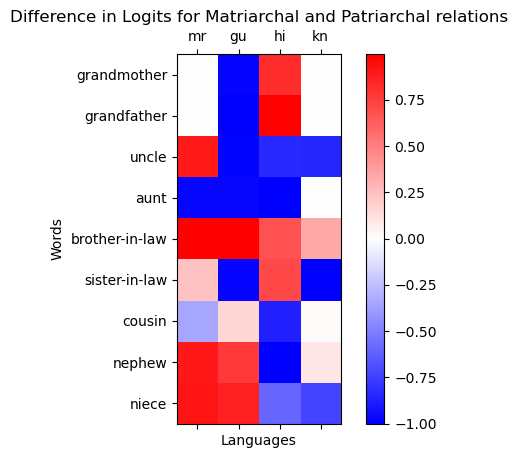

In [24]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# give colour custommed as max value as Pink and min value as blue and 0 as white
cax = ax.matshow(confusion_mat, cmap='bwr')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(lang_code_map[lang] for lang in final_res.keys()))
ax.set_yticklabels([''] + list(final_res[lang_script_list[0]].keys()))
plt.xlabel('Languages')
plt.ylabel('Words')
plt.title('Difference in Logits for Matriarchal and Patriarchal relations')
# save the image to a file
fig.savefig('results/logit_prob_diff_'+str(SAMPLE_SIZE)+'(2) 4 lang.png')
plt.show()



In [25]:
# index of ['ମାମୁଁ', 'ମଉସା'] in vocab of en_indic_tokenizer
# print(en_indic_tokenizer.convert_tokens_to_ids(['ମାମୁଁ', 'ମଉସା'])) #[3, 3] - wrong

# print(en_indic_tokenizer.vocab



In [26]:
# # import the test_sentences_eng.txt file data as sents

# # sents = ['The river is blue.', 'My uncle wearing blue coat.', 'My maternal aunt went to the river bank.', "The doctor went to bank for money."]
# sents=['My maternal aunt went to the river bank.', 'My maternal aunt loves me.', 
#        'My maternal aunt loves her grandchildren.', "My maternal aunt loves her children.", 
#        "My maternal aunt loves her family.",
#        ]   
# src_lang = "eng_Latn"

# tgt_lang = 'hin_Deva'
# # print(lang)
# translations, logits = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind)


In [27]:
print(translations)

['ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು. ', 'ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ. ', 'ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಅತ್ತಿಗೆ ಬ್ರಾಹ್ಮಣಳು. ', 'ನನ್ನ ಸೋದರಸಂಬಂಧಿ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಸೋದರಳಿಯ ಬ್ರಾಹ್ಮಣನಾಗಿದ್ದಾನೆ. ', 'ನನ್ನ ಸೋದರ ಸೊಸೆ ಬ್ರಾಹ್ಮಣಳು. ', 'ನನ್ನ ಅಜ್ಜಿ ಒಬ್ಬ ಕ್ಷತ್ರಿಯ. ']


In [28]:
print(logits)

tensor([-0.8970, -0.8960, -1.3037,  ..., -0.8960, -0.8965, -0.8965],
       dtype=torch.float16)


In [31]:
# for each logit in logits, convert it to prob using softmax
softmax_logits=[]
for lang in lang_script_list:
    print(lang)
    
    logits = output_logits[lang]
    softmax_logits = [softmax(logit, dim=-1) for logit in logits]
    # print(softmax_logits)
    # print(len(softmax_logits) ) # for each sentence translated)
    # print(softmax_logits[0].shape) # for each word in the sentence; vocab size

    max_prob_index = [torch.argmax(softmax_logit, dim=-1) for softmax_logit in softmax_logits]
    print(max_prob_index)

    top_10_indices = [torch.topk(softmax_logit, k=10, dim=-1) for softmax_logit in softmax_logits]
    print(top_10_indices)
    # from the top_10_indices, get the words in Hindi vocab using tokenizer.target_tokenizer
    word_list = []
    for i in top_10_indices:
        with en_indic_tokenizer.as_target_tokenizer():
            word_list.append(en_indic_tokenizer.batch_decode(i.indices))
    print(word_list)

# for each sentence, amongs all vocab logits, find the difference of [sum of matrirach words] - [sum of patriarch words]
# find the root word in english and as per lang, find the other Matriarch or Patriarch words based on relation code 

mar_Deva
[tensor(32967), tensor(56799), tensor(41565), tensor(11701), tensor(530), tensor(193), tensor(6702), tensor(28125), tensor(4569), tensor(32967)]
[torch.return_types.topk(
values=tensor([8.6963e-01, 2.5665e-02, 2.0615e-02, 4.7112e-03, 4.6005e-03, 1.8950e-03,
        1.5106e-03, 1.0262e-03, 5.0211e-04, 3.4785e-04], dtype=torch.float16),
indices=tensor([32967,   755, 56799, 29498,   740, 52359,    34,  8911,    53, 17946])), torch.return_types.topk(
values=tensor([8.8672e-01, 1.3672e-02, 1.3458e-02, 1.2642e-02, 9.4681e-03, 7.5493e-03,
        2.1973e-03, 1.0462e-03, 9.0885e-04, 8.4066e-04], dtype=torch.float16),
indices=tensor([56799, 15588, 32967, 52359, 16655,   755, 53208,  2911, 41565, 15597])), torch.return_types.topk(
values=tensor([9.0527e-01, 2.3575e-02, 1.1131e-02, 6.3438e-03, 2.9964e-03, 1.8101e-03,
        1.6232e-03, 1.1549e-03, 1.1282e-03, 7.9107e-04], dtype=torch.float16),
indices=tensor([41565, 24501, 56799,  7610, 34059, 22699,  9971,  6702, 62516, 11701])), torch

/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


# CONCLUSION

Found logits for ambiguos english words just before translating